In [1]:
from PIL import Image

In [2]:
orig_img = Image.open('sc.jpeg')

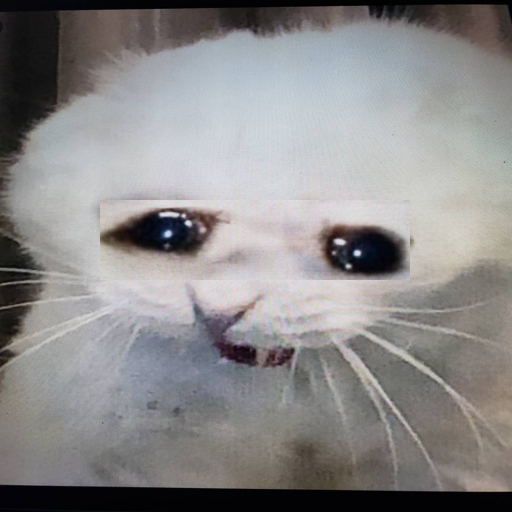

In [3]:
box = (100, 200, 410, 280)
box = (100, 200, 410, 280)
region = orig_img.resize((512, 512)).copy()
region = region.crop(box)
region = region.transpose(Image.ROTATE_180)
img_4 = orig_img.resize((512, 512)).copy()
img_4.paste(region, box)
img_4

In [4]:
from pylab import *

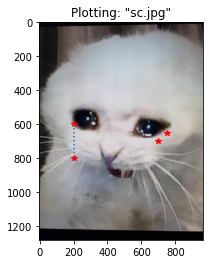

In [5]:
orig_imarray = array(orig_img)
imshow(orig_imarray)
x = [200, 200, 700, 750]
y = [600, 800, 700, 650]
plot(x, y, 'r*')
plot(x[:2], y[:2], ':')
title('Plotting: "sc.jpg"')
show()

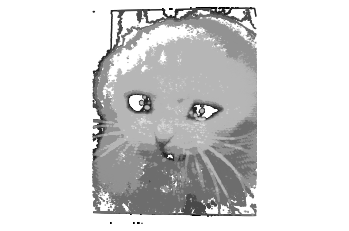

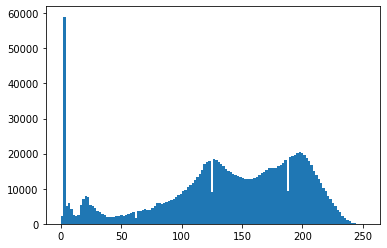

In [6]:
imarray = array(orig_img.convert('L'))
figure()
gray()
contour(imarray, origin='image')
axis('equal')
axis('off')
figure()
hist(imarray.flatten(),128)
show()

Щелкните в 3 точках
вы щелкнули:  [200, 200, 700, 750]


<ipython-input-7-c3f2c9b1f9f1>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  _x = ginput(3)


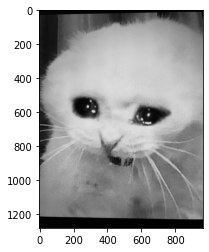

In [7]:
#im = array(orig_img.convert('L'))
imshow(imarray)
print('Щелкните в 3 точках')
_x = ginput(3)
print('вы щелкнули: ', x)
show()

3 255


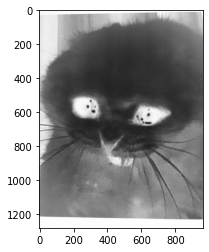

In [8]:
from numpy import *
#im = array(orig_img.convert('L'))
im2 = 255 - imarray
im3 = (100.0/255) * imarray + 100
im4 = 255.0 * (imarray/255.0) **2
imshow(im2)
print (int(im2.min()), int(im2.max()))

100 198


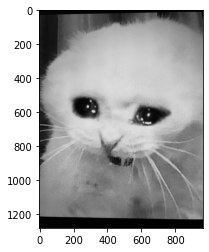

In [9]:
imshow(im3)
print (int(im3.min()), int(im3.max()))

0 249


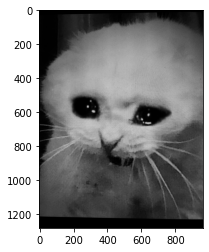

In [10]:
imshow(im4)
print (int(im4.min()), int(im4.max()))

In [11]:
def imresize(im, sz):
    pil_im = Image.fromarray(uint8(im))
    return array(pil_im.resize(sz))

def histeq(im, nbr_bins=256):
    imhist, bins = histogram(im.flatten(), nbr_bins)
    cdf = imhist.cumsum()
    cdf = 255 * cdf / cdf[-1]
    im2 = interp(im.flatten(), bins[:-1], cdf)
    return im2.reshape(im.shape), cdf

def compute_average(imlist):
    averageim = array(Image.open(imlist[0], 'f'))
    for imname in imlist[1:]:
        try:
            averageim += array(Image.open(imname))
        except:
            print (imname + '... пропущено')
            averageim /= len(imlist)
            
    return array(averageim, 'uint8')

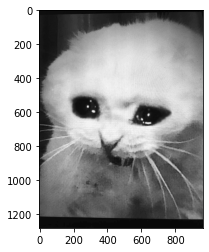

In [12]:
imshow(imarray)
im2, cdf = histeq(imarray)
imshow(im2)

In [13]:
def pca(X):
    num_data, dim = X.shape
    mean_X = X.mean(axis=0)
    X = X - mean_X
    if dim>num_data:
        M = dot(X, X.T)
        e, EV = linalg.eigh(M)
        tmp = dot(X.T, EV).T
        V = tmp[::-1]
        S = sqrt(e)[::-1]
        for i in range (V>shape[1]):
            V[:,i] /= S
    else:
        U, S, V = linalg.svd(X)
        V = V[:num_data]
        
    return V, S, mean_X

In [14]:
import os
def get_imlist(path):   
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]

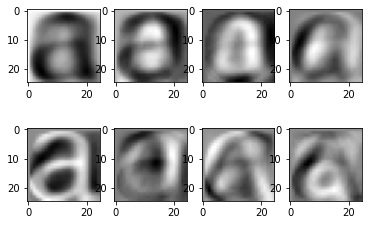

In [15]:
imlist = get_imlist('fontimages/') 
im = array(Image.open(imlist[0])) 
m,n = im.shape[:2]

immatrix = array([array(Image.open(imname)).flatten() for imname in imlist],'f')

V,S,immean = pca(immatrix)

figure()
gray()
subplot(2,4,1)
imshow(immean.reshape(m,n))
for i in range(7):
    subplot(2,4,i+2)
    imshow(V[i].reshape(m,n))
show()

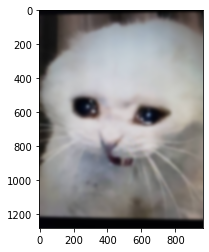

In [16]:
from numpy import *
from scipy.ndimage import filters
im2 = zeros(orig_imarray.shape)
for i in range(3):
    im2[:,:,i] = filters.gaussian_filter(orig_imarray[:,:,i], 8)
im2 = uint8(im2)
imshow(im2)

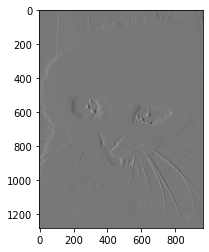

In [17]:
# Операторы Собеля
imx = zeros(imarray.shape)
plt.imshow(filters.sobel(imarray, 1, imx))

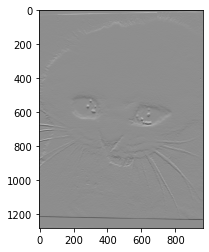

In [18]:
imy = zeros(imarray.shape)
plt.imshow(filters.sobel(imarray, 0, imy))

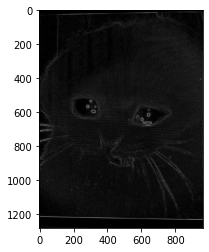

In [19]:
magnitude = sqrt(imx**2 + imy**2)
plt.imshow(magnitude)

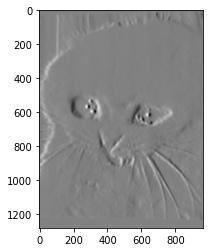

In [20]:
sigma = 5 # стандартное отклонение
plt.imshow(filters.gaussian_filter(imarray, (sigma, sigma), (0, 1), imx))

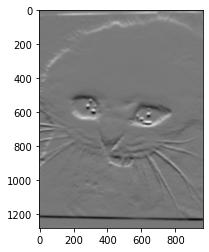

In [21]:
plt.imshow(filters.gaussian_filter(imarray, (sigma, sigma), (1, 0), imy))

Количество объектов:  415


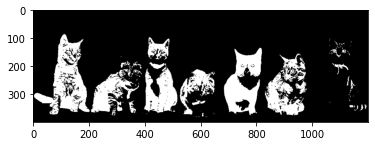

In [22]:
from scipy.ndimage import measurements, morphology

bin_im = array(Image.open('cats.jpeg').convert('L'))
bin_im = 1*(bin_im<128)
imshow(bin_im)
labels, nbr_objects = measurements.label(bin_im)
print("Количество объектов: ", nbr_objects)

Количество объектов: 8


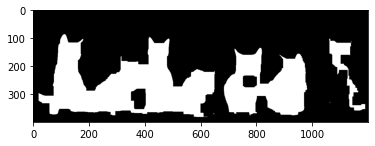

In [23]:
im_open = morphology.binary_closing(bin_im, ones((4, 4)), iterations = 10)
imshow(im_open)
labels_open, nbr_objects_open = measurements.label(im_open)
print("Количество объектов:", nbr_objects_open)

In [24]:
def denoise(im,U_init,tolerance=0.1,tau=0.125,tv_weight=100):    
    m,n = im.shape 

    U = U_init
    Px = im
    Py = im
    error = 1 
    
    while (error > tolerance):
        Uold = U
        
        GradUx = roll(U,-1,axis=1)-U
        GradUy = roll(U,-1,axis=0)-U
        
        PxNew = Px + (tau/tv_weight)*GradUx
        PyNew = Py + (tau/tv_weight)*GradUy
        NormNew = maximum(1,sqrt(PxNew**2+PyNew**2))
        
        Px = PxNew/NormNew
        Py = PyNew/NormNew
        
        RxPx = roll(Px,1,axis=1)
        RyPy = roll(Py,1,axis=0)
        
        DivP = (Px-RxPx)+(Py-RyPy)
        U = im + tv_weight*DivP
        
        error = linalg.norm(U-Uold)/sqrt(n*m);
        
    return U,im-U

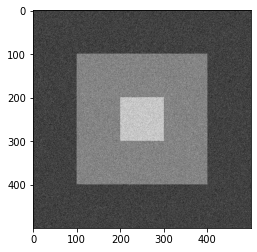

In [25]:
from numpy import random
im_noise = zeros((500, 500))
im_noise[100:400, 100:400] = 128
im_noise[200:300, 200:300] = 255
im_noise = im_noise + 30*random.standard_normal((500, 500))

U, T = denoise(im_noise, im_noise)
G = filters.gaussian_filter(im_noise, 10)

imshow(im_noise)

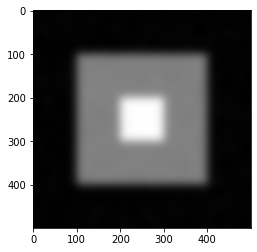

In [26]:
imshow(G)

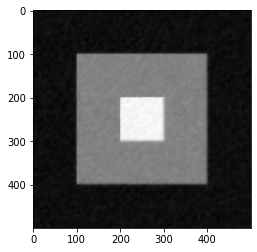

In [27]:
imshow(U)

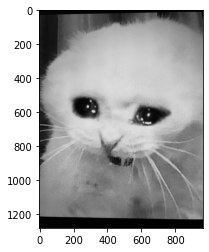

In [28]:
imshow(imarray)

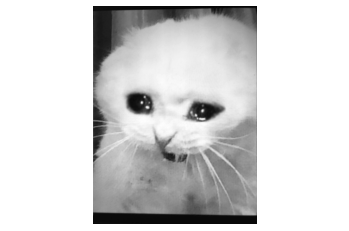

In [29]:
U, T = denoise(imarray, imarray)
figure()
gray()
imshow(U)
axis('equal')
axis('off')
show()